### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

# Packages

In [1]:
env = 'colab'  # 'pc', 'colab'
using_gpu = False

In [2]:
%%capture
git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Semi-Supervised-Labelling/master/'

def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    files = [
           'BCGDSolver.py',
           'DataProperties.py',
           'GradientDescentSolver.py',
           'GradientSolver.py',
           'Utils.py'  
    ]

    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

In [3]:
from sklearn.datasets import make_blobs
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
import timeit

# Plotting
import matplotlib.pyplot as plt

In [4]:
import Utils
import GradientSolver
import GradientDescentSolver
import DataProperties
import BCGDSolver
import importlib

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        Utils,
        GradientSolver,
        GradientDescentSolver,
        DataProperties,
        BCGDSolver
    ]
)

from Utils import *
from GradientSolver import GradientSolver
from GradientDescentSolver import GradientDescentSolver
from DataProperties import DataProperties
from BCGDSolver import BCGDSolver

# Data preparation

In [5]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

np.random.seed(numpy_seed)

Data shape: X: (1000, 2), Y: (1000,)


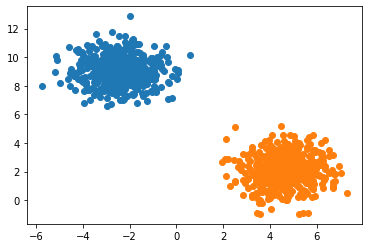

In [6]:
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state
)

def euclidian_similarity(Xi, Xj):
    return 1 / (norm(Xi - Xj) + 0.001)

weights = calc_weight_matrix(X, weight_func = euclidian_similarity)


Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')
plot_clusters(X, Y)

## Unlabel subset and visualize

Found 500 instances of object 0.0
We have to delabel 475 instances
Found 500 instances of object 1.0
We have to delabel 475 instances

    We have 950 unlabeled data
    Out of 1000
    


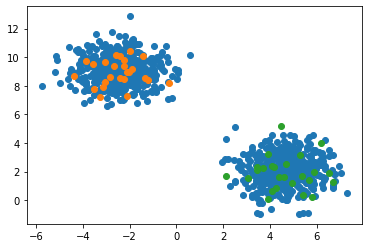

In [7]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

plot_clusters(X, Y_delabeled)

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [8]:
import collections
class_stats = collections.Counter(Y_delabeled)
assert(len(class_stats.keys()) == 3)  # 2 labeled classes and 1 unlabeled

# Gradient descent

In [9]:
solver = GradientDescentSolver(
    similarity_func = None, # euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.001
)

In [10]:
X.shape

(1000, 2)

In [11]:
Y_preds_GD = solver.solve(
    X, 
    Y_delabeled, 
    iter_limit = 10, 
    delta_loss_limit = 0.008, 
    stop_loss = 2198,
    weight_matrix = weights
)

Iteration: 0, Loss: 5852.532638240798, delta loss: 5852.532638240798
Iteration: 1, Loss: 5485.6653893242, delta loss: 366.8672489165983
Iteration: 2, Loss: 5297.3161154181125, delta loss: 188.34927390608755
Iteration: 3, Loss: 5190.351513321881, delta loss: 106.96460209623183
Iteration: 4, Loss: 5128.463019362752, delta loss: 61.88849395912894
Iteration: 5, Loss: 5092.372724416802, delta loss: 36.09029494594961
Iteration: 6, Loss: 5071.192439364718, delta loss: 21.1802850520844
Iteration: 7, Loss: 5058.665038150778, delta loss: 12.527401213939811
Iteration: 8, Loss: 5051.173665980241, delta loss: 7.4913721705370335
Iteration: 9, Loss: 5046.62252817491, delta loss: 4.551137805330654




Accuracy: 1.0


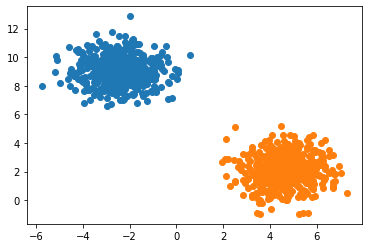

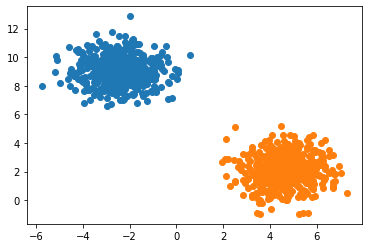

In [12]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_GD)
print(f'Accuracy: {accuracy_score(Y, Y_preds_GD)}')

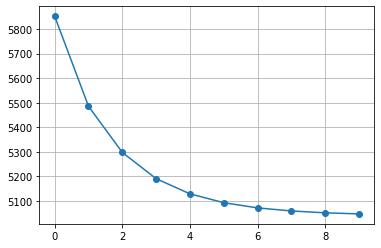

In [13]:
plt.plot(solver.losses, marker = 'o')
plt.grid()

# Block coordinates gradient descent (randomized)

## BCGD random permutations

In [14]:
random_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,

    bcgd_strategy = 'random permutation',
)

In [15]:
Y_preds_BCGD_permutation = random_solver.solve(
    X, 
    Y_delabeled, 
    iter_limit = 10, 
    delta_loss_limit = 0.008, 
    stop_loss= 2174,
    weight_matrix = weights
)

Iteration: 0, Loss: 5852.532638240798, Delta: 5852.532638240798
Iteration: 1, Loss: 5375.263745208419, Delta: 477.2688930323793
Iteration: 2, Loss: 5178.98873263971, Delta: 196.27501256870892
Iteration: 3, Loss: 5100.195919497402, Delta: 78.79281314230775
Iteration: 4, Loss: 5066.933428638211, Delta: 33.26249085919153
Iteration: 5, Loss: 5051.8939442626215, Delta: 15.039484375589382
Iteration: 6, Loss: 5045.128768726135, Delta: 6.765175536486822
Iteration: 7, Loss: 5041.747809622914, Delta: 3.380959103220448
Iteration: 8, Loss: 5040.002108523366, Delta: 1.745701099548569
Iteration: 9, Loss: 5038.996487383181, Delta: 1.005621140184303


Accuracy: 1.0


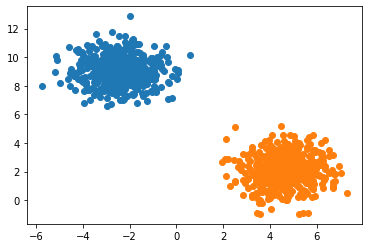

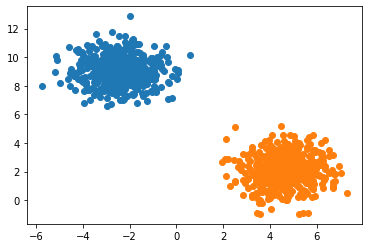

In [16]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_BCGD_permutation)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_permutation)}')

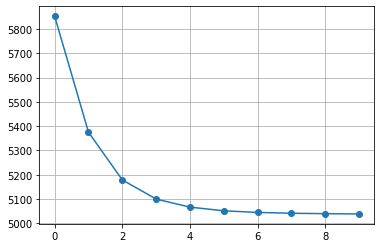

In [17]:
plt.plot(random_solver.losses, marker = 'o')
plt.grid()

## BCGD random sampling

In [18]:
BCGD_RS_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.00015,
    similarity_func = None,

    bcgd_strategy = 'random sampling'
)

In [19]:
Y_preds_BCGD_sampling = BCGD_RS_solver.solve(
    X = X, 
    Y = Y_delabeled, 
    iter_limit = 100,
    delta_loss_limit = 0.0,
    stop_loss= 2380,
    weight_matrix = weights
)

Iteration: 0, Loss: 5852.532638240798, Delta: 5852.532638240798
Iteration: 1, Loss: 5852.486462445505, Delta: 0.04617579529349314
Iteration: 2, Loss: 5852.382709959946, Delta: 0.10375248555919825
Iteration: 3, Loss: 5852.376437273661, Delta: 0.006272686284319207
Iteration: 4, Loss: 5852.341537981054, Delta: 0.034899292607406096
Iteration: 5, Loss: 5852.328438924664, Delta: 0.0130990563902742
Iteration: 6, Loss: 5852.316576880985, Delta: 0.01186204367877508
Iteration: 7, Loss: 5852.30616089726, Delta: 0.010415983724669786
Iteration: 8, Loss: 5852.286311036492, Delta: 0.019849860767862992
Iteration: 9, Loss: 5852.24399751776, Delta: 0.04231351873204403
Iteration: 10, Loss: 5852.220699238321, Delta: 0.023298279439586622
Iteration: 11, Loss: 5852.19075331712, Delta: 0.029945921201033343
Iteration: 12, Loss: 5852.127049051644, Delta: 0.0637042654761899
Iteration: 13, Loss: 5852.090752881695, Delta: 0.03629616994840035
Iteration: 14, Loss: 5852.066453961306, Delta: 0.024298920388901024
Itera

Accuracy: 0.571


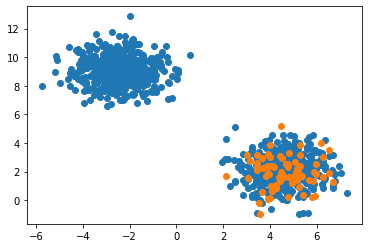

In [20]:
plot_clusters(
    X, Y_preds_BCGD_sampling
)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_sampling)}')

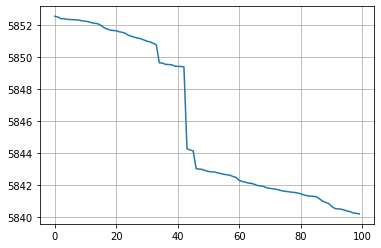

In [21]:
plt.plot(BCGD_RS_solver.losses)
plt.grid()

## BCGD cyclic

In [22]:
BCGD_cyclic_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,

    bcgd_strategy = 'cyclic'
)

In [24]:
Y_preds_BCGD_cyclic = BCGD_cyclic_solver.solve(
    X,
    Y_delabeled, 
    iter_limit = 10, 
    delta_loss_limit = 0.0001,
    stop_loss = 2300,
    weight_matrix = weights
)

Iteration: 0, Loss: 5852.532638240798, Delta: 5852.532638240798
Iteration: 1, Loss: 5383.38169306933, Delta: 469.15094517146827
Iteration: 2, Loss: 5160.130641867445, Delta: 223.25105120188528
Iteration: 3, Loss: 5085.495608265532, Delta: 74.63503360191316
Iteration: 4, Loss: 5057.8065144248185, Delta: 27.689093840713213
Iteration: 5, Loss: 5046.753284600918, Delta: 11.053229823900438
Iteration: 6, Loss: 5042.112902764877, Delta: 4.6403818360413425
Iteration: 7, Loss: 5039.927860435394, Delta: 2.1850423294827124
Iteration: 8, Loss: 5038.7765365994255, Delta: 1.1513238359684692
Iteration: 9, Loss: 5038.065369794376, Delta: 0.7111668050492881


Accuracy: 1.0


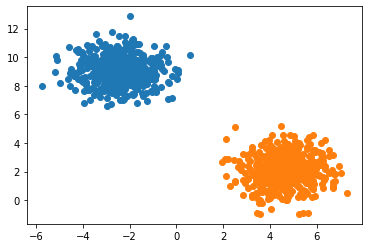

In [25]:
print(f'Accuracy: {accuracy_score(Y_preds_BCGD_cyclic, Y)}')
plot_clusters(
    X, Y_preds_BCGD_cyclic
)

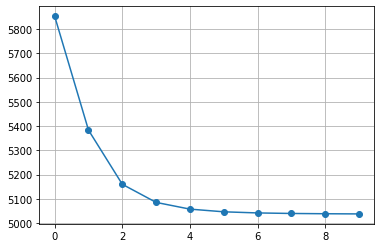

In [26]:
plt.plot(BCGD_cyclic_solver.losses, marker = 'o')
plt.grid()

# Model comparison

We will compare models based on:
- Clustering metrics
- CPU time
- Number of iterations
- Loss curves
- Distance metrics

In [27]:
learning_rate_strategy = 'lr_constant'
simil_func = None  # No feature yet
lr = 0.001

gd_solver = GradientDescentSolver(
    similarity_func = simil_func,
    lr_strategy = learning_rate_strategy,
    learning_rate = lr
)

bcgd_permut_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random permutation',
)

bcgd_sampling_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random sampling',
)

bcgd_cyclic_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'cyclic',
)

In [28]:
solvers = {
    'GD': gd_solver,
    'BCGD permutation': bcgd_permut_solver,
    'BCGD cyclic': bcgd_cyclic_solver,
    'BCGD sampling': bcgd_sampling_solver,
}

In [40]:
def compare_models(solvers_dict, X, Y_delabeled, iters_limit, delta_loss_limit, stop_loss, weights_matrix):
    predictions = {k:None for k in solvers_dict.keys()}
    losses = {k:None for k in solvers_dict.keys()}
    n_iterations = {k:None for k in solvers_dict.keys()}
    cpu_times = {k:None for k in solvers_dict.keys()}

    for model_name, model in solvers_dict.items():
        start = timeit.default_timer()
        Y_preds = model.solve(
            X,
            Y_delabeled,
            iter_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss= stop_loss,
            weight_matrix = weights_matrix
        )
        end = timeit.default_timer()
        predictions[model_name] = Y_preds
        losses[model_name] = model.losses
        n_iterations[model_name] = model.n_iterations
        cpu_times[model_name] = end - start
    
    # plot_accuracies(predictions)
    # plot_losses(losses)
    # plot_iterations(n_iterations)
    # plot_cpu_times(cpu_times)

    return predictions, losses, n_iterations, cpu_times

In [41]:
iters_limit = 15
delta_loss_limit = 0.0001
stop_loss= 4000

if using_gpu:
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()

    with tf.device(device_name):
        print(f'with GPU')
        preds, losses, n_iters, cpu_times = compare_models(
            solvers,
            X,
            Y_delabeled,
            iters_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss= stop_loss,
            weights_matrix = weights
        )

else:
    print(f'without GPU')
    preds, losses, n_iters, cpu_times = compare_models(
            solvers,
            X,
            Y_delabeled,
            iters_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss = stop_loss,
            weights_matrix =  weights
        )

accuracies = {name: accuracy_score(preds[name], Y) for name in solvers.keys()}

without GPU
Iteration: 0, Loss: 5852.532638240798, delta loss: 5852.532638240798
Iteration: 1, Loss: 5485.6653893242, delta loss: 366.8672489165983
Iteration: 2, Loss: 5297.3161154181125, delta loss: 188.34927390608755
Iteration: 3, Loss: 5190.351513321881, delta loss: 106.96460209623183
Iteration: 4, Loss: 5128.463019362752, delta loss: 61.88849395912894
Iteration: 5, Loss: 5092.372724416802, delta loss: 36.09029494594961
Iteration: 6, Loss: 5071.192439364718, delta loss: 21.1802850520844
Iteration: 7, Loss: 5058.665038150778, delta loss: 12.527401213939811
Iteration: 8, Loss: 5051.173665980241, delta loss: 7.4913721705370335
Iteration: 9, Loss: 5046.62252817491, delta loss: 4.551137805330654
Iteration: 10, Loss: 5043.795444390071, delta loss: 2.8270837848394876
Iteration: 11, Loss: 5041.985725185638, delta loss: 1.8097192044324402
Iteration: 12, Loss: 5040.782043653524, delta loss: 1.2036815321143877
Iteration: 13, Loss: 5039.9444126335275, delta loss: 0.8376310199964792
Iteration: 1

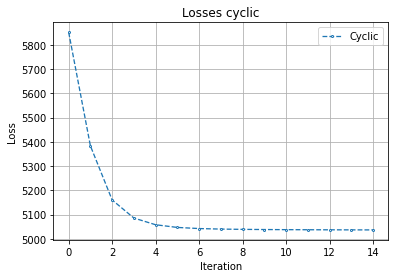

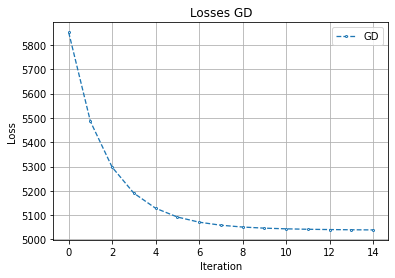

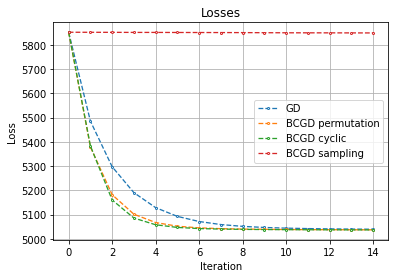

In [42]:
def plot_curves(curves_dict, title, y_label):
    _, ax = plt.subplots(figsize = (6, 4))

    for _, curve_res in curves_dict.items():
        ax.plot(
            curve_res,
            marker = 'o',
            linestyle = '--',
            linewidth = 1.3,
            markerfacecolor = 'white',
            markersize = 2
        )
    plt.legend(list(curves_dict.keys()))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.grid()


plot_curves({'Cyclic':losses['BCGD cyclic']}, 'Losses cyclic', y_label = 'Loss')
plot_curves({'GD':losses['GD']}, 'Losses GD', y_label = 'Loss')
plot_curves(losses, 'Losses', y_label = 'Loss')

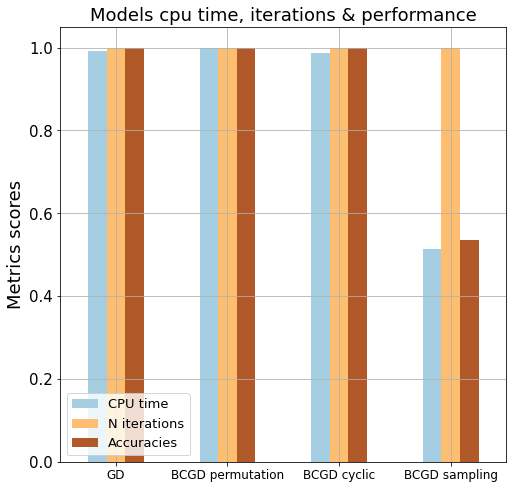

In [43]:
def plot_bar_metrics(metrics_df):
    
    ax = metrics_df.plot.bar(
        rot = 0,
        ylabel = 'Metrics results',
        cmap = 'Paired',
        figsize = (8, 8)
    )

    ax.set_title('Models cpu time, iterations & performance', fontsize = 18)
    ax.set_ylabel('Metrics scores', fontsize = 18)
    ax.tick_params(axis = 'y', labelsize = 15)
    ax.tick_params(axis = 'x', labelsize = 12)
    ax.legend(loc = 3, prop = {'size': 13})
    plt.grid()

def normalize_cols(dataframe):
    cols = dataframe.columns
    for c in cols:
        dataframe[c] = dataframe[c] / dataframe[c].max()
    

bar_metrics = pd.DataFrame.from_dict(cpu_times, orient='index', columns = ['CPU time'])
bar_metrics['N iterations'] = n_iters.values()
bar_metrics['Accuracies'] = accuracies.values()

normalize_cols(bar_metrics)
plot_bar_metrics(bar_metrics)

In [44]:
print(accuracies)
print(n_iters)
print(cpu_times)

{'GD': 1.0, 'BCGD permutation': 1.0, 'BCGD cyclic': 1.0, 'BCGD sampling': 0.536}
{'GD': 15, 'BCGD permutation': 15, 'BCGD cyclic': 15, 'BCGD sampling': 15}
{'GD': 37.680151992000106, 'BCGD permutation': 37.988130015000024, 'BCGD cyclic': 37.495182602, 'BCGD sampling': 19.545026675999907}


# Real dataset

In [ ]:
wine=datasets.load_wine()

#Conver to pandas dataframe
data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

data = data.loc[
    (data['target'] == 1) | (data['target'] == 0),
    ['od280/od315_of_diluted_wines', 'alcohol', 'target']
]

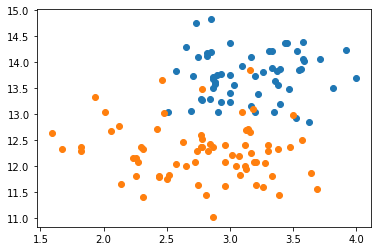

In [ ]:
X_real = data.loc[
    :,
    ['od280/od315_of_diluted_wines', 'alcohol']
].values
Y_real = data['target'].values

plot_clusters(
    X_real,
    Y_real
)

In [ ]:
Y_real_delabeled = delabel_data(
    Y_real,
    labeled_percent = 0.06, # DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

Found 59 instances of object 0.0
We have to delabel 55 instances
Found 71 instances of object 1.0
We have to delabel 66 instances


In [ ]:
plot_clusters(
    X_real,
    Y_real_delabeled
)

NameError: name 'plot_clusters' is not defined

In [ ]:
solver = GradientDescentSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None
)

Y_real_preds = solver.solve(
    X_real,
    Y_real_delabeled,
    iter_limit=50,
    delta_loss_limit = 0.003
)

NameError: name 'GradientDescentSolver' is not defined

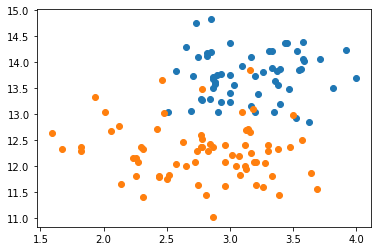

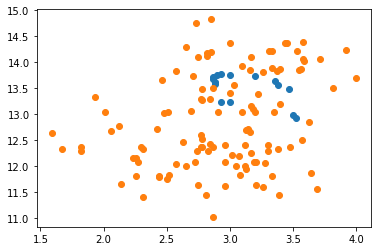

In [ ]:
plot_clusters(
    X_real,
    Y_real
)
plot_clusters(
    X_real,
    Y_real_preds
)